In [27]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import scipy.stats as ss
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw

import networkx as nx

from utils.graph_utils import *
from dataset.preprocess import *
from predict_logp.predict_logp import *
import torch_geometric as pyg

In [11]:
def compute_baseline_error(scores):
    mean = scores.mean()
    sq_sum = np.sum(np.square(scores - mean)) / len(scores)
    return sq_sum

In [2]:
def read_data(dataset_path):
    all_logp = []
    all_smiles = []
    with open(dataset_path, newline='') as csvfile:
        reader = csv.reader(csvfile)

        for i, (logp, smiles) in enumerate(reader):
            # Some fields are empty, if logp is empty it will be caught by the exception. If smile is empty, conditional kicks in.
            try:
                if smiles is not None:
                    all_logp.append(float(logp))
                    all_smiles.append(smiles)
                else:
                    continue
            except:
                print("Row " + str(i) + "was not read.")
                continue
    return all_logp, all_smiles

In [17]:
scores, smiles = read_data("/Users/ADChen/Downloads/MD/2col/NPRBD_6VYO_A_1_F.Orderable_zinc_db_enaHLL.2col.csv")

In [18]:
train_data, valid_data, test_data = create_datasets(scores, smiles)
test_labels = np.array(test_data.logp)

In [19]:
sort_idx = np.argsort(test_labels)
test_labels_sorted = test_labels[sort_idx]


In [21]:
compute_baseline_error(test_labels)

1.02446528114315

In [22]:
int(len(test_labels)//20)

61013

In [24]:
test_labels[61013]

-5.492459

In [6]:
sum(test_labels<-11)

102717

In [88]:
# For weighted sampling 
def dock_score_weights(scores):                        
    weights = np.zeros(len(scores))                                          
    for idx, score in enumerate(scores):
        if score < -6:
            weight = 1
        else:
            weight = 0.1
        weights[idx] = weight                               
    return weights      

In [89]:
len(test_labels)

1166893

In [90]:
from scipy.stats import pearsonr
def tail_corr(a, b):
    assert len(a) == len(b)
    tail_corr = np.array([pearsonr(a[:i], b[:i])[0] for i in np.arange(30, len(a))], dtype=float)
    tail_corr = np.insert(tail_corr, 0, np.repeat(np.nan, 30))
    return tail_corr

# Histograms

Want to explore parameter space of exponential weighting and just upsampling. 
- Try plotting different random exponentials on distribution of scores.
- Figure out how to do explore upsampling

In [90]:
global _abc

In [84]:
np.percentile(np.arange(10), 25)

2.25

In [82]:
np.random.uniform(0.5,1,1)[0]

0.8281952972559741

In [75]:
np.exp(-(x-min(test_labels))/4)/4

array([0.25      , 0.24217403, 0.23459303, 0.22724936, 0.22013557,
       0.21324447, 0.20656908, 0.20010267, 0.19383867, 0.18777077,
       0.18189281, 0.17619886, 0.17068315, 0.1653401 , 0.16016431,
       0.15515054, 0.15029372, 0.14558895, 0.14103144, 0.13661661,
       0.13233998, 0.12819722, 0.12418415, 0.1202967 , 0.11653094,
       0.11288307, 0.10934939, 0.10592633, 0.10261042, 0.09939832,
       0.09628676, 0.09327261, 0.09035281, 0.08752442, 0.08478456,
       0.08213048, 0.07955947, 0.07706895, 0.07465639, 0.07231936,
       0.07005548, 0.06786247, 0.06573811, 0.06368025, 0.06168681,
       0.05975577, 0.05788518, 0.05607315, 0.05431784, 0.05261748,
       0.05097035, 0.04937478, 0.04782916, 0.04633192, 0.04488155,
       0.04347658, 0.0421156 , 0.04079721, 0.0395201 , 0.03828297,
       0.03708456, 0.03592367, 0.03479912, 0.03370977, 0.03265452,
       0.03163231, 0.0306421 , 0.02968288, 0.02875369, 0.02785359,
       0.02698166, 0.02613703, 0.02531884, 0.02452626, 0.02375

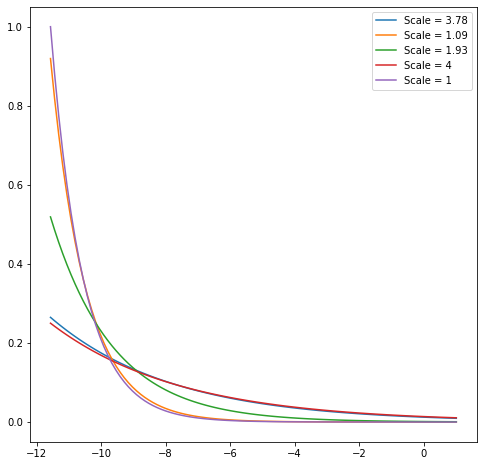

In [93]:
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)
rv_max = ss.expon(loc = min(test_labels), scale = 4)
rv_min = ss.expon(loc = min(test_labels), scale = 1)
x = np.linspace(min(test_labels),max(test_labels),100)
for i in np.random.uniform(1,4,3):
    ax.plot(x, ss.expon(loc = min(test_labels), scale = i).pdf(x), label = "Scale = " + str(round(i,2)))
ax.plot(x, rv_max.pdf(x), label = "Scale = 4")
ax.plot(x, rv_min.pdf(x), label = "Scale = 1");
ax.legend()

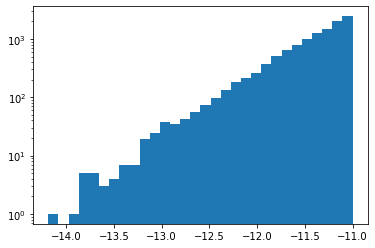

In [10]:
plt.hist(test_labels[test_labels<-11], bins = 30, log=True);

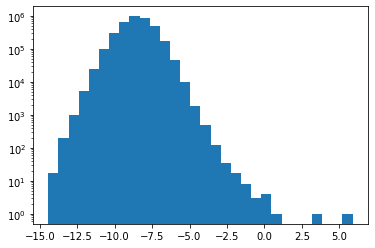

In [15]:
train_labels = np.array(train_data.logp)
plt.hist(train_labels, bins = 30, log=True);

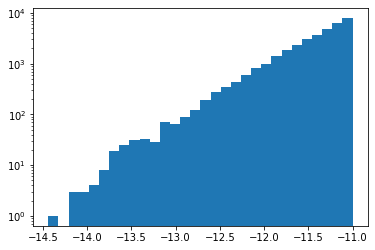

In [16]:
plt.hist(train_labels[train_labels < -11], bins = 30, log=True);

# Latent space visuzliations

Extracting PATH/MNIST/raw/train-images-idx3-ubyte.gz to PATH/MNIST/raw



Extracting PATH/MNIST/raw/train-labels-idx1-ubyte.gz to PATH/MNIST/raw


Extracting PATH/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH/MNIST/raw


Extracting PATH/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH/MNIST/raw
Processing...
Done!


Epoch 0, Batch idx 0, loss 0.6959919333457947
Epoch 0, Batch idx 1, loss 0.695286750793457
Epoch 0, Batch idx 2, loss 0.6947616338729858
Epoch 0, Batch idx 3, loss 0.6940229535102844
Epoch 0, Batch idx 4, loss 0.6934084892272949
Epoch 0, Batch idx 5, loss 0.6927887797355652
Epoch 0, Batch idx 6, loss 0.6922029852867126
Epoch 0, Batch idx 7, loss 0.691521942615509
Epoch 0, Batch idx 8, loss 0.6909253597259521
Epoch 0, Batch idx 9, loss 0.6901482343673706
Epoch 0, Batch idx 10, loss 0.689348042011261
Epoch 0, Batch idx 11, loss 0.6888720393180847
Epoch 0, Batch idx 12, loss 0.6882135272026062
Epoch 0, Batch idx 13, loss 0.6877740621566772
Epoch 0, Batch idx 14, loss 0.6863370537757874
Epoch 0, Batch idx 15, loss 0.6866862773895264
Epoch 0, Batch idx 16, loss 0.684883713722229
Epoch 0, Batch idx 17, loss 0.6845617294311523
Epoch 0, Batch idx 18, loss 0.6839882135391235
Epoch 0, Batch idx 19, loss 0

Epoch 0, Batch idx 209, loss 0.24135908484458923
Epoch 0, Batch idx 210, loss 0.249583899974823
Epoch 0, Batch idx 211, loss 0.20847027003765106
Epoch 0, Batch idx 212, loss 0.22330008447170258
Epoch 0, Batch idx 213, loss 0.23073789477348328
Epoch 0, Batch idx 214, loss 0.21716195344924927
Epoch 0, Batch idx 215, loss 0.215619295835495
Epoch 0, Batch idx 216, loss 0.2240402102470398
Epoch 0, Batch idx 217, loss 0.23448199033737183
Epoch 0, Batch idx 218, loss 0.22628407180309296
Epoch 0, Batch idx 219, loss 0.21141603589057922
Epoch 0, Batch idx 220, loss 0.20640422403812408
Epoch 0, Batch idx 221, loss 0.22659969329833984
Epoch 0, Batch idx 222, loss 0.22052136063575745
Epoch 0, Batch idx 223, loss 0.21989524364471436
Epoch 0, Batch idx 224, loss 0.1854127049446106
Epoch 0, Batch idx 225, loss 0.20051376521587372
Epoch 0, Batch idx 226, loss 0.2431122362613678
Epoch 0, Batch idx 227, loss 0.23782026767730713
Epoch 0, Batch idx 228, loss 0.1817774474620819
Epoch 0, Batch idx 229, loss

Epoch 0, Batch idx 409, loss 0.128827303647995
Epoch 0, Batch idx 410, loss 0.17882825434207916
Epoch 0, Batch idx 411, loss 0.1617927998304367
Epoch 0, Batch idx 412, loss 0.17820273339748383
Epoch 0, Batch idx 413, loss 0.1667674332857132
Epoch 0, Batch idx 414, loss 0.18486201763153076
Epoch 0, Batch idx 415, loss 0.19893717765808105
Epoch 0, Batch idx 416, loss 0.20064429938793182
Epoch 0, Batch idx 417, loss 0.2236364334821701
Epoch 0, Batch idx 418, loss 0.18211455643177032
Epoch 0, Batch idx 419, loss 0.18395844101905823
Epoch 0, Batch idx 420, loss 0.16142156720161438
Epoch 0, Batch idx 421, loss 0.16171739995479584
Epoch 0, Batch idx 422, loss 0.18103580176830292
Epoch 0, Batch idx 423, loss 0.165458083152771
Epoch 0, Batch idx 424, loss 0.17891058325767517
Epoch 0, Batch idx 425, loss 0.16908898949623108
Epoch 0, Batch idx 426, loss 0.16917875409126282
Epoch 0, Batch idx 427, loss 0.17449188232421875
Epoch 0, Batch idx 428, loss 0.1686609983444214
Epoch 0, Batch idx 429, loss

Epoch 0, Batch idx 607, loss 0.17587070167064667
Epoch 0, Batch idx 608, loss 0.1691206693649292
Epoch 0, Batch idx 609, loss 0.14234068989753723
Epoch 0, Batch idx 610, loss 0.15712344646453857
Epoch 0, Batch idx 611, loss 0.16616122424602509
Epoch 0, Batch idx 612, loss 0.17277604341506958
Epoch 0, Batch idx 613, loss 0.15494807064533234
Epoch 0, Batch idx 614, loss 0.1765812486410141
Epoch 0, Batch idx 615, loss 0.17045435309410095
Epoch 0, Batch idx 616, loss 0.17816364765167236
Epoch 0, Batch idx 617, loss 0.16517098248004913
Epoch 0, Batch idx 618, loss 0.16764304041862488
Epoch 0, Batch idx 619, loss 0.15650255978107452
Epoch 0, Batch idx 620, loss 0.13537487387657166
Epoch 0, Batch idx 621, loss 0.17470978200435638
Epoch 0, Batch idx 622, loss 0.14434115588665009
Epoch 0, Batch idx 623, loss 0.1792331486940384
Epoch 0, Batch idx 624, loss 0.16161677241325378
Epoch 0, Batch idx 625, loss 0.14952032268047333
Epoch 0, Batch idx 626, loss 0.16282963752746582
Epoch 0, Batch idx 627,

Epoch 0, Batch idx 820, loss 0.14856044948101044
Epoch 0, Batch idx 821, loss 0.15539662539958954
Epoch 0, Batch idx 822, loss 0.17232824862003326
Epoch 0, Batch idx 823, loss 0.15138190984725952
Epoch 0, Batch idx 824, loss 0.14739327132701874
Epoch 0, Batch idx 825, loss 0.13491635024547577
Epoch 0, Batch idx 826, loss 0.15472233295440674
Epoch 0, Batch idx 827, loss 0.18852926790714264
Epoch 0, Batch idx 828, loss 0.13813258707523346
Epoch 0, Batch idx 829, loss 0.11473359912633896
Epoch 0, Batch idx 830, loss 0.13665854930877686
Epoch 0, Batch idx 831, loss 0.16985838115215302
Epoch 0, Batch idx 832, loss 0.1519845426082611
Epoch 0, Batch idx 833, loss 0.14252619445323944
Epoch 0, Batch idx 834, loss 0.14869600534439087
Epoch 0, Batch idx 835, loss 0.1584668904542923
Epoch 0, Batch idx 836, loss 0.12994250655174255
Epoch 0, Batch idx 837, loss 0.14365072548389435
Epoch 0, Batch idx 838, loss 0.16683439910411835
Epoch 0, Batch idx 839, loss 0.15475331246852875
Epoch 0, Batch idx 840

Epoch 0, Batch idx 1013, loss 0.1447698026895523
Epoch 0, Batch idx 1014, loss 0.14179882407188416
Epoch 0, Batch idx 1015, loss 0.12689919769763947
Epoch 0, Batch idx 1016, loss 0.13416583836078644
Epoch 0, Batch idx 1017, loss 0.14740510284900665
Epoch 0, Batch idx 1018, loss 0.15484552085399628
Epoch 0, Batch idx 1019, loss 0.1388782262802124
Epoch 0, Batch idx 1020, loss 0.12624183297157288
Epoch 0, Batch idx 1021, loss 0.1540486216545105
Epoch 0, Batch idx 1022, loss 0.1346811056137085
Epoch 0, Batch idx 1023, loss 0.13169416785240173
Epoch 0, Batch idx 1024, loss 0.12523594498634338
Epoch 0, Batch idx 1025, loss 0.143961101770401
Epoch 0, Batch idx 1026, loss 0.15187138319015503
Epoch 0, Batch idx 1027, loss 0.16381198167800903
Epoch 0, Batch idx 1028, loss 0.1515142023563385
Epoch 0, Batch idx 1029, loss 0.1509859263896942
Epoch 0, Batch idx 1030, loss 0.14424210786819458
Epoch 0, Batch idx 1031, loss 0.14304165542125702
Epoch 0, Batch idx 1032, loss 0.16837382316589355
Epoch 0,

Epoch 0, Batch idx 1220, loss 0.15403981506824493
Epoch 0, Batch idx 1221, loss 0.14497576653957367
Epoch 0, Batch idx 1222, loss 0.15022273361682892
Epoch 0, Batch idx 1223, loss 0.13655434548854828
Epoch 0, Batch idx 1224, loss 0.1324208825826645
Epoch 0, Batch idx 1225, loss 0.13492903113365173
Epoch 0, Batch idx 1226, loss 0.13218064606189728
Epoch 0, Batch idx 1227, loss 0.14243996143341064
Epoch 0, Batch idx 1228, loss 0.14424541592597961
Epoch 0, Batch idx 1229, loss 0.1157536581158638
Epoch 0, Batch idx 1230, loss 0.13626472651958466
Epoch 0, Batch idx 1231, loss 0.1444554179906845
Epoch 0, Batch idx 1232, loss 0.1499229520559311
Epoch 0, Batch idx 1233, loss 0.13791990280151367
Epoch 0, Batch idx 1234, loss 0.15358789265155792
Epoch 0, Batch idx 1235, loss 0.14287492632865906
Epoch 0, Batch idx 1236, loss 0.14008767902851105
Epoch 0, Batch idx 1237, loss 0.13364042341709137
Epoch 0, Batch idx 1238, loss 0.1504109501838684
Epoch 0, Batch idx 1239, loss 0.13592971861362457
Epoch

Epoch 0, Batch idx 1423, loss 0.11265486478805542
Epoch 0, Batch idx 1424, loss 0.13947437703609467
Epoch 0, Batch idx 1425, loss 0.14752353727817535
Epoch 0, Batch idx 1426, loss 0.121243916451931
Epoch 0, Batch idx 1427, loss 0.13447846472263336
Epoch 0, Batch idx 1428, loss 0.13083688914775848
Epoch 0, Batch idx 1429, loss 0.14120139181613922
Epoch 0, Batch idx 1430, loss 0.11769230663776398
Epoch 0, Batch idx 1431, loss 0.11283254623413086
Epoch 0, Batch idx 1432, loss 0.12148114293813705
Epoch 0, Batch idx 1433, loss 0.13294042646884918
Epoch 0, Batch idx 1434, loss 0.1311272531747818
Epoch 0, Batch idx 1435, loss 0.14241978526115417
Epoch 0, Batch idx 1436, loss 0.11577904224395752
Epoch 0, Batch idx 1437, loss 0.13474828004837036
Epoch 0, Batch idx 1438, loss 0.14168013632297516
Epoch 0, Batch idx 1439, loss 0.1514844447374344
Epoch 0, Batch idx 1440, loss 0.12906359136104584
Epoch 0, Batch idx 1441, loss 0.12587319314479828
Epoch 0, Batch idx 1442, loss 0.11577877402305603
Epoc

Epoch 0, Batch idx 1629, loss 0.11831840127706528
Epoch 0, Batch idx 1630, loss 0.1141393631696701
Epoch 0, Batch idx 1631, loss 0.13265864551067352
Epoch 0, Batch idx 1632, loss 0.11348842084407806
Epoch 0, Batch idx 1633, loss 0.12555237114429474
Epoch 0, Batch idx 1634, loss 0.13828037679195404
Epoch 0, Batch idx 1635, loss 0.12495145946741104
Epoch 0, Batch idx 1636, loss 0.12100597470998764
Epoch 0, Batch idx 1637, loss 0.11336983740329742
Epoch 0, Batch idx 1638, loss 0.1207008957862854
Epoch 0, Batch idx 1639, loss 0.12040326744318008
Epoch 0, Batch idx 1640, loss 0.12293794006109238
Epoch 0, Batch idx 1641, loss 0.11491397768259048
Epoch 0, Batch idx 1642, loss 0.1229645311832428
Epoch 0, Batch idx 1643, loss 0.12028969824314117
Epoch 0, Batch idx 1644, loss 0.11311610043048859
Epoch 0, Batch idx 1645, loss 0.11310353875160217
Epoch 0, Batch idx 1646, loss 0.1318448930978775
Epoch 0, Batch idx 1647, loss 0.10586125403642654
Epoch 0, Batch idx 1648, loss 0.10802996158599854
Epoc

Epoch 0, Batch idx 1839, loss 0.11468392610549927
Epoch 0, Batch idx 1840, loss 0.10965193808078766
Epoch 0, Batch idx 1841, loss 0.11724914610385895
Epoch 0, Batch idx 1842, loss 0.10838305205106735
Epoch 0, Batch idx 1843, loss 0.11029733717441559
Epoch 0, Batch idx 1844, loss 0.1224566400051117
Epoch 0, Batch idx 1845, loss 0.10518235713243484
Epoch 0, Batch idx 1846, loss 0.11210886389017105
Epoch 0, Batch idx 1847, loss 0.11392608284950256
Epoch 0, Batch idx 1848, loss 0.10954051464796066
Epoch 0, Batch idx 1849, loss 0.10883817076683044
Epoch 0, Batch idx 1850, loss 0.12114161252975464
Epoch 0, Batch idx 1851, loss 0.12056466192007065
Epoch 0, Batch idx 1852, loss 0.13411235809326172
Epoch 0, Batch idx 1853, loss 0.11553923785686493
Epoch 0, Batch idx 1854, loss 0.12502539157867432
Epoch 0, Batch idx 1855, loss 0.11973009258508682
Epoch 0, Batch idx 1856, loss 0.10924281924962997
Epoch 0, Batch idx 1857, loss 0.09923405200242996
Epoch 0, Batch idx 1858, loss 0.11734480410814285
E

Epoch 0, Batch idx 2045, loss 0.11598572134971619
Epoch 0, Batch idx 2046, loss 0.12127204984426498
Epoch 0, Batch idx 2047, loss 0.10467056185007095
Epoch 0, Batch idx 2048, loss 0.09918248653411865
Epoch 0, Batch idx 2049, loss 0.0944683775305748
Epoch 0, Batch idx 2050, loss 0.11231859028339386
Epoch 0, Batch idx 2051, loss 0.1189461275935173
Epoch 0, Batch idx 2052, loss 0.10587330162525177
Epoch 0, Batch idx 2053, loss 0.11275133490562439
Epoch 0, Batch idx 2054, loss 0.11041910946369171
Epoch 0, Batch idx 2055, loss 0.11497540026903152
Epoch 0, Batch idx 2056, loss 0.11306311190128326
Epoch 0, Batch idx 2057, loss 0.10540406405925751
Epoch 0, Batch idx 2058, loss 0.11136722564697266
Epoch 0, Batch idx 2059, loss 0.10397560894489288
Epoch 0, Batch idx 2060, loss 0.10632450878620148
Epoch 0, Batch idx 2061, loss 0.09877185523509979
Epoch 0, Batch idx 2062, loss 0.11731386184692383
Epoch 0, Batch idx 2063, loss 0.10674075782299042
Epoch 0, Batch idx 2064, loss 0.11505071818828583
Ep

Epoch 0, Batch idx 2252, loss 0.08401820808649063
Epoch 0, Batch idx 2253, loss 0.10125070810317993
Epoch 0, Batch idx 2254, loss 0.1174580454826355
Epoch 0, Batch idx 2255, loss 0.11653906852006912
Epoch 0, Batch idx 2256, loss 0.1140110045671463
Epoch 0, Batch idx 2257, loss 0.10516677796840668
Epoch 0, Batch idx 2258, loss 0.10415772348642349
Epoch 0, Batch idx 2259, loss 0.1040482148528099
Epoch 0, Batch idx 2260, loss 0.10364347696304321
Epoch 0, Batch idx 2261, loss 0.11248127371072769
Epoch 0, Batch idx 2262, loss 0.08656845986843109
Epoch 0, Batch idx 2263, loss 0.1123146042227745
Epoch 0, Batch idx 2264, loss 0.11344919353723526
Epoch 0, Batch idx 2265, loss 0.09762305021286011
Epoch 0, Batch idx 2266, loss 0.10614824295043945
Epoch 0, Batch idx 2267, loss 0.11419486999511719
Epoch 0, Batch idx 2268, loss 0.10256990790367126
Epoch 0, Batch idx 2269, loss 0.10040745139122009
Epoch 0, Batch idx 2270, loss 0.1098974198102951
Epoch 0, Batch idx 2271, loss 0.1092977300286293
Epoch 

Epoch 0, Batch idx 2455, loss 0.1091623529791832
Epoch 0, Batch idx 2456, loss 0.09450248628854752
Epoch 0, Batch idx 2457, loss 0.11190919578075409
Epoch 0, Batch idx 2458, loss 0.10044270753860474
Epoch 0, Batch idx 2459, loss 0.11141197383403778
Epoch 0, Batch idx 2460, loss 0.10946866124868393
Epoch 0, Batch idx 2461, loss 0.10570887476205826
Epoch 0, Batch idx 2462, loss 0.10111501067876816
Epoch 0, Batch idx 2463, loss 0.10851478576660156
Epoch 0, Batch idx 2464, loss 0.09163623303174973
Epoch 0, Batch idx 2465, loss 0.09817072749137878
Epoch 0, Batch idx 2466, loss 0.10111512243747711
Epoch 0, Batch idx 2467, loss 0.10178343206644058
Epoch 0, Batch idx 2468, loss 0.1163211464881897
Epoch 0, Batch idx 2469, loss 0.0933556854724884
Epoch 0, Batch idx 2470, loss 0.10052725672721863
Epoch 0, Batch idx 2471, loss 0.11504235863685608
Epoch 0, Batch idx 2472, loss 0.1073300689458847
Epoch 0, Batch idx 2473, loss 0.08990994095802307
Epoch 0, Batch idx 2474, loss 0.1178274154663086
Epoch

Epoch 0, Batch idx 2659, loss 0.09412037581205368
Epoch 0, Batch idx 2660, loss 0.11274988949298859
Epoch 0, Batch idx 2661, loss 0.09815870970487595
Epoch 0, Batch idx 2662, loss 0.10670245438814163
Epoch 0, Batch idx 2663, loss 0.11130748689174652
Epoch 0, Batch idx 2664, loss 0.11802735924720764
Epoch 0, Batch idx 2665, loss 0.08972567319869995
Epoch 0, Batch idx 2666, loss 0.1055297926068306
Epoch 0, Batch idx 2667, loss 0.1014980673789978
Epoch 0, Batch idx 2668, loss 0.10988546162843704
Epoch 0, Batch idx 2669, loss 0.104518823325634
Epoch 0, Batch idx 2670, loss 0.0993279367685318
Epoch 0, Batch idx 2671, loss 0.09977784752845764
Epoch 0, Batch idx 2672, loss 0.09655299782752991
Epoch 0, Batch idx 2673, loss 0.1161109209060669
Epoch 0, Batch idx 2674, loss 0.10885991901159286
Epoch 0, Batch idx 2675, loss 0.1011127158999443
Epoch 0, Batch idx 2676, loss 0.10079586505889893
Epoch 0, Batch idx 2677, loss 0.08773508667945862
Epoch 0, Batch idx 2678, loss 0.1008361205458641
Epoch 0,

Epoch 0, Batch idx 2864, loss 0.0940040573477745
Epoch 0, Batch idx 2865, loss 0.09199648350477219
Epoch 0, Batch idx 2866, loss 0.09239520877599716
Epoch 0, Batch idx 2867, loss 0.10628283023834229
Epoch 0, Batch idx 2868, loss 0.09943997114896774
Epoch 0, Batch idx 2869, loss 0.09160197526216507
Epoch 0, Batch idx 2870, loss 0.10894835740327835
Epoch 0, Batch idx 2871, loss 0.0956679955124855
Epoch 0, Batch idx 2872, loss 0.09233216941356659
Epoch 0, Batch idx 2873, loss 0.09439070522785187
Epoch 0, Batch idx 2874, loss 0.10329077392816544
Epoch 0, Batch idx 2875, loss 0.09527339786291122
Epoch 0, Batch idx 2876, loss 0.10119526088237762
Epoch 0, Batch idx 2877, loss 0.10805501788854599
Epoch 0, Batch idx 2878, loss 0.09593098610639572
Epoch 0, Batch idx 2879, loss 0.09801971912384033
Epoch 0, Batch idx 2880, loss 0.11046090722084045
Epoch 0, Batch idx 2881, loss 0.09972718358039856
Epoch 0, Batch idx 2882, loss 0.09426138550043106
Epoch 0, Batch idx 2883, loss 0.11156483739614487
Ep

Epoch 0, Batch idx 3067, loss 0.10205630213022232
Epoch 0, Batch idx 3068, loss 0.0948016420006752
Epoch 0, Batch idx 3069, loss 0.11439193040132523
Epoch 0, Batch idx 3070, loss 0.08242873847484589
Epoch 0, Batch idx 3071, loss 0.09692475199699402
Epoch 0, Batch idx 3072, loss 0.09881646186113358
Epoch 0, Batch idx 3073, loss 0.11060137301683426
Epoch 0, Batch idx 3074, loss 0.0962231382727623
Epoch 0, Batch idx 3075, loss 0.11169084161520004
Epoch 0, Batch idx 3076, loss 0.10287115722894669
Epoch 0, Batch idx 3077, loss 0.09568389505147934
Epoch 0, Batch idx 3078, loss 0.10115264356136322
Epoch 0, Batch idx 3079, loss 0.10562211275100708
Epoch 0, Batch idx 3080, loss 0.08370761573314667
Epoch 0, Batch idx 3081, loss 0.11327940225601196
Epoch 0, Batch idx 3082, loss 0.07767196744680405
Epoch 0, Batch idx 3083, loss 0.09192489087581635
Epoch 0, Batch idx 3084, loss 0.0982852503657341
Epoch 0, Batch idx 3085, loss 0.0818323865532875
Epoch 0, Batch idx 3086, loss 0.11306578665971756
Epoc

Epoch 0, Batch idx 3258, loss 0.08256043493747711
Epoch 0, Batch idx 3259, loss 0.08191680908203125
Epoch 0, Batch idx 3260, loss 0.1014452576637268
Epoch 0, Batch idx 3261, loss 0.11000444740056992
Epoch 0, Batch idx 3262, loss 0.09958500415086746
Epoch 0, Batch idx 3263, loss 0.11420644074678421
Epoch 0, Batch idx 3264, loss 0.09646468609571457
Epoch 0, Batch idx 3265, loss 0.09106422960758209
Epoch 0, Batch idx 3266, loss 0.08724202960729599
Epoch 0, Batch idx 3267, loss 0.08655665814876556
Epoch 0, Batch idx 3268, loss 0.11190439760684967
Epoch 0, Batch idx 3269, loss 0.09663362801074982
Epoch 0, Batch idx 3270, loss 0.08494596183300018
Epoch 0, Batch idx 3271, loss 0.09395180642604828
Epoch 0, Batch idx 3272, loss 0.08909529447555542
Epoch 0, Batch idx 3273, loss 0.07517077773809433
Epoch 0, Batch idx 3274, loss 0.10282272845506668
Epoch 0, Batch idx 3275, loss 0.1107550710439682
Epoch 0, Batch idx 3276, loss 0.09300343692302704
Epoch 0, Batch idx 3277, loss 0.08341258019208908
Ep

Epoch 0, Batch idx 3454, loss 0.10687678307294846
Epoch 0, Batch idx 3455, loss 0.09139713644981384
Epoch 0, Batch idx 3456, loss 0.11640740185976028
Epoch 0, Batch idx 3457, loss 0.09342677891254425
Epoch 0, Batch idx 3458, loss 0.08646411448717117
Epoch 0, Batch idx 3459, loss 0.10103285312652588
Epoch 0, Batch idx 3460, loss 0.09513989090919495
Epoch 0, Batch idx 3461, loss 0.1039554700255394
Epoch 0, Batch idx 3462, loss 0.08349646627902985
Epoch 0, Batch idx 3463, loss 0.08507407456636429
Epoch 0, Batch idx 3464, loss 0.09147968143224716
Epoch 0, Batch idx 3465, loss 0.0891379788517952
Epoch 0, Batch idx 3466, loss 0.09179320931434631
Epoch 0, Batch idx 3467, loss 0.10378532856702805
Epoch 0, Batch idx 3468, loss 0.09400776773691177
Epoch 0, Batch idx 3469, loss 0.0989563837647438
Epoch 0, Batch idx 3470, loss 0.10567131638526917
Epoch 0, Batch idx 3471, loss 0.10789894312620163
Epoch 0, Batch idx 3472, loss 0.10911385715007782
Epoch 0, Batch idx 3473, loss 0.10003557056188583
Epo

Epoch 0, Batch idx 3652, loss 0.08669062703847885
Epoch 0, Batch idx 3653, loss 0.08602501451969147
Epoch 0, Batch idx 3654, loss 0.09262681752443314
Epoch 0, Batch idx 3655, loss 0.10316086560487747
Epoch 0, Batch idx 3656, loss 0.0911061018705368
Epoch 0, Batch idx 3657, loss 0.10534203797578812
Epoch 0, Batch idx 3658, loss 0.09047342091798782
Epoch 0, Batch idx 3659, loss 0.0908990204334259
Epoch 0, Batch idx 3660, loss 0.09751128405332565
Epoch 0, Batch idx 3661, loss 0.08471862971782684
Epoch 0, Batch idx 3662, loss 0.09232714772224426
Epoch 0, Batch idx 3663, loss 0.0922188088297844
Epoch 0, Batch idx 3664, loss 0.09174257516860962
Epoch 0, Batch idx 3665, loss 0.09833560883998871
Epoch 0, Batch idx 3666, loss 0.10325358808040619
Epoch 0, Batch idx 3667, loss 0.10411988198757172
Epoch 0, Batch idx 3668, loss 0.11884810775518417
Epoch 0, Batch idx 3669, loss 0.10335725545883179
Epoch 0, Batch idx 3670, loss 0.08363891392946243
Epoch 0, Batch idx 3671, loss 0.10424481332302094
Epo

Epoch 0, Batch idx 3855, loss 0.11001716554164886
Epoch 0, Batch idx 3856, loss 0.10350817441940308
Epoch 0, Batch idx 3857, loss 0.09479571133852005
Epoch 0, Batch idx 3858, loss 0.086846724152565
Epoch 0, Batch idx 3859, loss 0.110041543841362
Epoch 0, Batch idx 3860, loss 0.08365481346845627
Epoch 0, Batch idx 3861, loss 0.09593743830919266
Epoch 0, Batch idx 3862, loss 0.0866779014468193
Epoch 0, Batch idx 3863, loss 0.09522508829832077
Epoch 0, Batch idx 3864, loss 0.10212472081184387
Epoch 0, Batch idx 3865, loss 0.09182599931955338
Epoch 0, Batch idx 3866, loss 0.09689129889011383
Epoch 0, Batch idx 3867, loss 0.08907175809144974
Epoch 0, Batch idx 3868, loss 0.08715381473302841
Epoch 0, Batch idx 3869, loss 0.08417310565710068
Epoch 0, Batch idx 3870, loss 0.10271380841732025
Epoch 0, Batch idx 3871, loss 0.08826315402984619
Epoch 0, Batch idx 3872, loss 0.11028268188238144
Epoch 0, Batch idx 3873, loss 0.093852698802948
Epoch 0, Batch idx 3874, loss 0.0976235643029213
Epoch 0,

Epoch 0, Batch idx 4059, loss 0.09288712590932846
Epoch 0, Batch idx 4060, loss 0.08993411809206009
Epoch 0, Batch idx 4061, loss 0.08748791366815567
Epoch 0, Batch idx 4062, loss 0.09206345677375793
Epoch 0, Batch idx 4063, loss 0.10151176154613495
Epoch 0, Batch idx 4064, loss 0.09959414601325989
Epoch 0, Batch idx 4065, loss 0.09103775769472122
Epoch 0, Batch idx 4066, loss 0.0941464751958847
Epoch 0, Batch idx 4067, loss 0.10419308394193649
Epoch 0, Batch idx 4068, loss 0.08899001777172089
Epoch 0, Batch idx 4069, loss 0.08950144797563553
Epoch 0, Batch idx 4070, loss 0.08988382667303085
Epoch 0, Batch idx 4071, loss 0.09315010905265808
Epoch 0, Batch idx 4072, loss 0.08623088151216507
Epoch 0, Batch idx 4073, loss 0.10121387988328934
Epoch 0, Batch idx 4074, loss 0.0939536765217781
Epoch 0, Batch idx 4075, loss 0.08481867611408234
Epoch 0, Batch idx 4076, loss 0.08869237452745438
Epoch 0, Batch idx 4077, loss 0.0931970626115799
Epoch 0, Batch idx 4078, loss 0.08655986189842224
Epo

Epoch 0, Batch idx 4258, loss 0.09986575692892075
Epoch 0, Batch idx 4259, loss 0.08193995803594589
Epoch 0, Batch idx 4260, loss 0.09004303812980652
Epoch 0, Batch idx 4261, loss 0.08696756511926651
Epoch 0, Batch idx 4262, loss 0.08324118703603745
Epoch 0, Batch idx 4263, loss 0.0981595367193222
Epoch 0, Batch idx 4264, loss 0.0994078740477562
Epoch 0, Batch idx 4265, loss 0.10135813802480698
Epoch 0, Batch idx 4266, loss 0.0864815041422844
Epoch 0, Batch idx 4267, loss 0.08024555444717407
Epoch 0, Batch idx 4268, loss 0.09874636679887772
Epoch 0, Batch idx 4269, loss 0.08586415648460388
Epoch 0, Batch idx 4270, loss 0.08888310939073563
Epoch 0, Batch idx 4271, loss 0.09127283096313477
Epoch 0, Batch idx 4272, loss 0.08357025682926178
Epoch 0, Batch idx 4273, loss 0.09161504358053207
Epoch 0, Batch idx 4274, loss 0.08411163836717606
Epoch 0, Batch idx 4275, loss 0.09640926122665405
Epoch 0, Batch idx 4276, loss 0.08300992101430893
Epoch 0, Batch idx 4277, loss 0.09936926513910294
Epo

Epoch 0, Batch idx 4451, loss 0.07114161550998688
Epoch 0, Batch idx 4452, loss 0.09261919558048248
Epoch 0, Batch idx 4453, loss 0.08072974532842636
Epoch 0, Batch idx 4454, loss 0.08669763803482056
Epoch 0, Batch idx 4455, loss 0.08480950444936752
Epoch 0, Batch idx 4456, loss 0.10103444755077362
Epoch 0, Batch idx 4457, loss 0.08649718761444092
Epoch 0, Batch idx 4458, loss 0.10376583784818649
Epoch 0, Batch idx 4459, loss 0.09731415659189224
Epoch 0, Batch idx 4460, loss 0.08194857835769653
Epoch 0, Batch idx 4461, loss 0.08804304897785187
Epoch 0, Batch idx 4462, loss 0.0986081063747406
Epoch 0, Batch idx 4463, loss 0.0998774841427803
Epoch 0, Batch idx 4464, loss 0.08222898095846176
Epoch 0, Batch idx 4465, loss 0.09372831135988235
Epoch 0, Batch idx 4466, loss 0.10158086568117142
Epoch 0, Batch idx 4467, loss 0.10651031136512756
Epoch 0, Batch idx 4468, loss 0.08632291853427887
Epoch 0, Batch idx 4469, loss 0.08300936222076416
Epoch 0, Batch idx 4470, loss 0.09484074264764786
Ep

Epoch 0, Batch idx 4637, loss 0.09370161592960358
Epoch 0, Batch idx 4638, loss 0.09605643153190613
Epoch 0, Batch idx 4639, loss 0.09038614481687546
Epoch 0, Batch idx 4640, loss 0.09647080302238464
Epoch 0, Batch idx 4641, loss 0.09502963721752167
Epoch 0, Batch idx 4642, loss 0.10243269801139832
Epoch 0, Batch idx 4643, loss 0.09431670606136322
Epoch 0, Batch idx 4644, loss 0.08399558812379837
Epoch 0, Batch idx 4645, loss 0.08914482593536377
Epoch 0, Batch idx 4646, loss 0.09447923302650452
Epoch 0, Batch idx 4647, loss 0.09287148714065552
Epoch 0, Batch idx 4648, loss 0.0931619256734848
Epoch 0, Batch idx 4649, loss 0.0831228643655777
Epoch 0, Batch idx 4650, loss 0.0937100425362587
Epoch 0, Batch idx 4651, loss 0.08587254583835602
Epoch 0, Batch idx 4652, loss 0.0911947637796402
Epoch 0, Batch idx 4653, loss 0.0933620035648346
Epoch 0, Batch idx 4654, loss 0.10703229159116745
Epoch 0, Batch idx 4655, loss 0.10359688848257065
Epoch 0, Batch idx 4656, loss 0.09189470112323761
Epoch

Epoch 0, Batch idx 4827, loss 0.09368772059679031
Epoch 0, Batch idx 4828, loss 0.09582138061523438
Epoch 0, Batch idx 4829, loss 0.09141593426465988
Epoch 0, Batch idx 4830, loss 0.08897750079631805
Epoch 0, Batch idx 4831, loss 0.08969949185848236
Epoch 0, Batch idx 4832, loss 0.10276836156845093
Epoch 0, Batch idx 4833, loss 0.0954257920384407
Epoch 0, Batch idx 4834, loss 0.07347183674573898
Epoch 0, Batch idx 4835, loss 0.08713944256305695
Epoch 0, Batch idx 4836, loss 0.09520141780376434
Epoch 0, Batch idx 4837, loss 0.08284883946180344
Epoch 0, Batch idx 4838, loss 0.07821934670209885
Epoch 0, Batch idx 4839, loss 0.08875106275081635
Epoch 0, Batch idx 4840, loss 0.09873074293136597
Epoch 0, Batch idx 4841, loss 0.09488844126462936
Epoch 0, Batch idx 4842, loss 0.0760139673948288
Epoch 0, Batch idx 4843, loss 0.09708257764577866
Epoch 0, Batch idx 4844, loss 0.08852409571409225
Epoch 0, Batch idx 4845, loss 0.09019921720027924
Epoch 0, Batch idx 4846, loss 0.10359812527894974
Ep

Epoch 0, Batch idx 5016, loss 0.07785522192716599
Epoch 0, Batch idx 5017, loss 0.08907871693372726
Epoch 0, Batch idx 5018, loss 0.08031631261110306
Epoch 0, Batch idx 5019, loss 0.09527692943811417
Epoch 0, Batch idx 5020, loss 0.09522154927253723
Epoch 0, Batch idx 5021, loss 0.09439089149236679
Epoch 0, Batch idx 5022, loss 0.08237447589635849
Epoch 0, Batch idx 5023, loss 0.09264440089464188
Epoch 0, Batch idx 5024, loss 0.08753719180822372
Epoch 0, Batch idx 5025, loss 0.09356345981359482
Epoch 0, Batch idx 5026, loss 0.1059763953089714
Epoch 0, Batch idx 5027, loss 0.08688252419233322
Epoch 0, Batch idx 5028, loss 0.09112107008695602
Epoch 0, Batch idx 5029, loss 0.10086250305175781
Epoch 0, Batch idx 5030, loss 0.08228214085102081
Epoch 0, Batch idx 5031, loss 0.08405116945505142
Epoch 0, Batch idx 5032, loss 0.07970358431339264
Epoch 0, Batch idx 5033, loss 0.08600543439388275
Epoch 0, Batch idx 5034, loss 0.0750328078866005
Epoch 0, Batch idx 5035, loss 0.08920852839946747
Ep

Epoch 0, Batch idx 5212, loss 0.09185264259576797
Epoch 0, Batch idx 5213, loss 0.09760088473558426
Epoch 0, Batch idx 5214, loss 0.0996304452419281
Epoch 0, Batch idx 5215, loss 0.08360132575035095
Epoch 0, Batch idx 5216, loss 0.08095484972000122
Epoch 0, Batch idx 5217, loss 0.09757722914218903
Epoch 0, Batch idx 5218, loss 0.08216527104377747
Epoch 0, Batch idx 5219, loss 0.090985007584095
Epoch 0, Batch idx 5220, loss 0.0977490171790123
Epoch 0, Batch idx 5221, loss 0.07913058996200562
Epoch 0, Batch idx 5222, loss 0.09425123035907745
Epoch 0, Batch idx 5223, loss 0.09099743515253067
Epoch 0, Batch idx 5224, loss 0.08875137567520142
Epoch 0, Batch idx 5225, loss 0.0964769572019577
Epoch 0, Batch idx 5226, loss 0.1075299009680748
Epoch 0, Batch idx 5227, loss 0.08701257407665253
Epoch 0, Batch idx 5228, loss 0.10115823894739151
Epoch 0, Batch idx 5229, loss 0.08034265041351318
Epoch 0, Batch idx 5230, loss 0.0917869508266449
Epoch 0, Batch idx 5231, loss 0.07964293658733368
Epoch 0

Epoch 0, Batch idx 5410, loss 0.08808263391256332
Epoch 0, Batch idx 5411, loss 0.08613891899585724
Epoch 0, Batch idx 5412, loss 0.10573524236679077
Epoch 0, Batch idx 5413, loss 0.08214852958917618
Epoch 0, Batch idx 5414, loss 0.09627676010131836
Epoch 0, Batch idx 5415, loss 0.07227020710706711
Epoch 0, Batch idx 5416, loss 0.09791063517332077
Epoch 0, Batch idx 5417, loss 0.09333553910255432
Epoch 0, Batch idx 5418, loss 0.09569063782691956
Epoch 0, Batch idx 5419, loss 0.08861623704433441
Epoch 0, Batch idx 5420, loss 0.08824441581964493
Epoch 0, Batch idx 5421, loss 0.08582386374473572
Epoch 0, Batch idx 5422, loss 0.07919180393218994
Epoch 0, Batch idx 5423, loss 0.08929137140512466
Epoch 0, Batch idx 5424, loss 0.1008494645357132
Epoch 0, Batch idx 5425, loss 0.07680604606866837
Epoch 0, Batch idx 5426, loss 0.09253543615341187
Epoch 0, Batch idx 5427, loss 0.08860377967357635
Epoch 0, Batch idx 5428, loss 0.08451057225465775
Epoch 0, Batch idx 5429, loss 0.07888542860746384
E

Epoch 0, Batch idx 5605, loss 0.08245246112346649
Epoch 0, Batch idx 5606, loss 0.08593545854091644
Epoch 0, Batch idx 5607, loss 0.0918375551700592
Epoch 0, Batch idx 5608, loss 0.09991378337144852
Epoch 0, Batch idx 5609, loss 0.06811407953500748
Epoch 0, Batch idx 5610, loss 0.09073811769485474
Epoch 0, Batch idx 5611, loss 0.09772654622793198
Epoch 0, Batch idx 5612, loss 0.07673314958810806
Epoch 0, Batch idx 5613, loss 0.08147739619016647
Epoch 0, Batch idx 5614, loss 0.0920315533876419
Epoch 0, Batch idx 5615, loss 0.08009424060583115
Epoch 0, Batch idx 5616, loss 0.09628089517354965
Epoch 0, Batch idx 5617, loss 0.08113938570022583
Epoch 0, Batch idx 5618, loss 0.09669309854507446
Epoch 0, Batch idx 5619, loss 0.06236794963479042
Epoch 0, Batch idx 5620, loss 0.0939299538731575
Epoch 0, Batch idx 5621, loss 0.0893937200307846
Epoch 0, Batch idx 5622, loss 0.09097759425640106
Epoch 0, Batch idx 5623, loss 0.1042315885424614
Epoch 0, Batch idx 5624, loss 0.10324461758136749
Epoch

Epoch 0, Batch idx 5798, loss 0.07760053873062134
Epoch 0, Batch idx 5799, loss 0.08867684006690979
Epoch 0, Batch idx 5800, loss 0.0933946818113327
Epoch 0, Batch idx 5801, loss 0.08759593963623047
Epoch 0, Batch idx 5802, loss 0.10369131714105606
Epoch 0, Batch idx 5803, loss 0.06901629269123077
Epoch 0, Batch idx 5804, loss 0.09313322603702545
Epoch 0, Batch idx 5805, loss 0.09208209812641144
Epoch 0, Batch idx 5806, loss 0.10948043316602707
Epoch 0, Batch idx 5807, loss 0.0996384397149086
Epoch 0, Batch idx 5808, loss 0.09199319779872894
Epoch 0, Batch idx 5809, loss 0.09819986671209335
Epoch 0, Batch idx 5810, loss 0.08842143416404724
Epoch 0, Batch idx 5811, loss 0.09256280213594437
Epoch 0, Batch idx 5812, loss 0.09047790616750717
Epoch 0, Batch idx 5813, loss 0.10170499980449677
Epoch 0, Batch idx 5814, loss 0.07929729670286179
Epoch 0, Batch idx 5815, loss 0.08400759100914001
Epoch 0, Batch idx 5816, loss 0.08249619603157043
Epoch 0, Batch idx 5817, loss 0.08842794597148895
Ep

Epoch 0, Batch idx 5991, loss 0.09984425455331802
Epoch 0, Batch idx 5992, loss 0.09907950460910797
Epoch 0, Batch idx 5993, loss 0.08595248311758041
Epoch 0, Batch idx 5994, loss 0.07577383518218994
Epoch 0, Batch idx 5995, loss 0.0818197950720787
Epoch 0, Batch idx 5996, loss 0.07976076006889343
Epoch 0, Batch idx 5997, loss 0.08486346900463104
Epoch 0, Batch idx 5998, loss 0.09172756969928741
Epoch 0, Batch idx 5999, loss 0.09890663623809814
Epoch 0, Batch idx 6000, loss 0.08634290844202042
Epoch 0, Batch idx 6001, loss 0.0736476480960846
Epoch 0, Batch idx 6002, loss 0.08939656615257263
Epoch 0, Batch idx 6003, loss 0.09301009774208069
Epoch 0, Batch idx 6004, loss 0.09973975270986557
Epoch 0, Batch idx 6005, loss 0.10306902229785919
Epoch 0, Batch idx 6006, loss 0.09100789576768875
Epoch 0, Batch idx 6007, loss 0.08831192553043365
Epoch 0, Batch idx 6008, loss 0.09524870663881302
Epoch 0, Batch idx 6009, loss 0.09084932506084442
Epoch 0, Batch idx 6010, loss 0.10432001203298569
Ep

Epoch 0, Batch idx 6189, loss 0.08006816357374191
Epoch 0, Batch idx 6190, loss 0.09491796791553497
Epoch 0, Batch idx 6191, loss 0.08345404267311096
Epoch 0, Batch idx 6192, loss 0.09262052178382874
Epoch 0, Batch idx 6193, loss 0.09018232673406601
Epoch 0, Batch idx 6194, loss 0.08744529634714127
Epoch 0, Batch idx 6195, loss 0.08430812507867813
Epoch 0, Batch idx 6196, loss 0.08717230707406998
Epoch 0, Batch idx 6197, loss 0.09238757193088531
Epoch 0, Batch idx 6198, loss 0.10896368324756622
Epoch 0, Batch idx 6199, loss 0.09750996530056
Epoch 0, Batch idx 6200, loss 0.07085864245891571
Epoch 0, Batch idx 6201, loss 0.09201224893331528
Epoch 0, Batch idx 6202, loss 0.07309748232364655
Epoch 0, Batch idx 6203, loss 0.09701677411794662
Epoch 0, Batch idx 6204, loss 0.08109292387962341
Epoch 0, Batch idx 6205, loss 0.09923137724399567
Epoch 0, Batch idx 6206, loss 0.08830200880765915
Epoch 0, Batch idx 6207, loss 0.08609358966350555
Epoch 0, Batch idx 6208, loss 0.09099169820547104
Epo

Epoch 0, Batch idx 6391, loss 0.089956134557724
Epoch 0, Batch idx 6392, loss 0.09208866208791733
Epoch 0, Batch idx 6393, loss 0.10203494876623154
Epoch 0, Batch idx 6394, loss 0.10313031077384949
Epoch 0, Batch idx 6395, loss 0.08438479900360107
Epoch 0, Batch idx 6396, loss 0.09790956974029541
Epoch 0, Batch idx 6397, loss 0.09395474940538406
Epoch 0, Batch idx 6398, loss 0.09185373783111572
Epoch 0, Batch idx 6399, loss 0.09375963360071182
Epoch 0, Batch idx 6400, loss 0.0905078575015068
Epoch 0, Batch idx 6401, loss 0.10187814384698868
Epoch 0, Batch idx 6402, loss 0.09123916923999786
Epoch 0, Batch idx 6403, loss 0.09119193255901337
Epoch 0, Batch idx 6404, loss 0.08146362751722336
Epoch 0, Batch idx 6405, loss 0.08397438377141953
Epoch 0, Batch idx 6406, loss 0.0938384011387825
Epoch 0, Batch idx 6407, loss 0.07589364051818848
Epoch 0, Batch idx 6408, loss 0.08995688706636429
Epoch 0, Batch idx 6409, loss 0.08427976071834564
Epoch 0, Batch idx 6410, loss 0.0955098494887352
Epoch

Epoch 0, Batch idx 6584, loss 0.07904304563999176
Epoch 0, Batch idx 6585, loss 0.0955364927649498
Epoch 0, Batch idx 6586, loss 0.07591912150382996
Epoch 0, Batch idx 6587, loss 0.0928463563323021
Epoch 0, Batch idx 6588, loss 0.09048991650342941
Epoch 0, Batch idx 6589, loss 0.06974876672029495
Epoch 0, Batch idx 6590, loss 0.09920724481344223
Epoch 0, Batch idx 6591, loss 0.0744563639163971
Epoch 0, Batch idx 6592, loss 0.08814296126365662
Epoch 0, Batch idx 6593, loss 0.09283972531557083
Epoch 0, Batch idx 6594, loss 0.10088858008384705
Epoch 0, Batch idx 6595, loss 0.0991896539926529
Epoch 0, Batch idx 6596, loss 0.08654627203941345
Epoch 0, Batch idx 6597, loss 0.07765693217515945
Epoch 0, Batch idx 6598, loss 0.0913180261850357
Epoch 0, Batch idx 6599, loss 0.09201639890670776
Epoch 0, Batch idx 6600, loss 0.09186416119337082
Epoch 0, Batch idx 6601, loss 0.07210105657577515
Epoch 0, Batch idx 6602, loss 0.09321917593479156
Epoch 0, Batch idx 6603, loss 0.08502814918756485
Epoch

Epoch 0, Batch idx 6789, loss 0.08062055706977844
Epoch 0, Batch idx 6790, loss 0.07580152153968811
Epoch 0, Batch idx 6791, loss 0.09478475898504257
Epoch 0, Batch idx 6792, loss 0.08808637410402298
Epoch 0, Batch idx 6793, loss 0.09894669055938721
Epoch 0, Batch idx 6794, loss 0.10209312289953232
Epoch 0, Batch idx 6795, loss 0.08962392807006836
Epoch 0, Batch idx 6796, loss 0.08955999463796616
Epoch 0, Batch idx 6797, loss 0.10522642731666565
Epoch 0, Batch idx 6798, loss 0.09379282593727112
Epoch 0, Batch idx 6799, loss 0.08846072852611542
Epoch 0, Batch idx 6800, loss 0.0820489153265953
Epoch 0, Batch idx 6801, loss 0.08273746818304062
Epoch 0, Batch idx 6802, loss 0.09011412411928177
Epoch 0, Batch idx 6803, loss 0.07582880556583405
Epoch 0, Batch idx 6804, loss 0.1031656339764595
Epoch 0, Batch idx 6805, loss 0.089558444917202
Epoch 0, Batch idx 6806, loss 0.09577801823616028
Epoch 0, Batch idx 6807, loss 0.08929073810577393
Epoch 0, Batch idx 6808, loss 0.08110522478818893
Epoc

Epoch 0, Batch idx 6984, loss 0.08965130895376205
Epoch 0, Batch idx 6985, loss 0.07619758695363998
Epoch 0, Batch idx 6986, loss 0.10548917949199677
Epoch 0, Batch idx 6987, loss 0.081600122153759
Epoch 0, Batch idx 6988, loss 0.09425093233585358
Epoch 0, Batch idx 6989, loss 0.0819023847579956
Epoch 0, Batch idx 6990, loss 0.09055611491203308
Epoch 0, Batch idx 6991, loss 0.09834998100996017
Epoch 0, Batch idx 6992, loss 0.07587629556655884
Epoch 0, Batch idx 6993, loss 0.07612153142690659
Epoch 0, Batch idx 6994, loss 0.09666242450475693
Epoch 0, Batch idx 6995, loss 0.08669201284646988
Epoch 0, Batch idx 6996, loss 0.08242165297269821
Epoch 0, Batch idx 6997, loss 0.0980646163225174
Epoch 0, Batch idx 6998, loss 0.08667544275522232
Epoch 0, Batch idx 6999, loss 0.09262976050376892
Epoch 0, Batch idx 7000, loss 0.08526264131069183
Epoch 0, Batch idx 7001, loss 0.09047790616750717
Epoch 0, Batch idx 7002, loss 0.10593188554048538
Epoch 0, Batch idx 7003, loss 0.07910817861557007
Epoc

Epoch 0, Batch idx 7180, loss 0.08544543385505676
Epoch 0, Batch idx 7181, loss 0.09905748814344406
Epoch 0, Batch idx 7182, loss 0.09886704385280609
Epoch 0, Batch idx 7183, loss 0.09027823805809021
Epoch 0, Batch idx 7184, loss 0.07787883281707764
Epoch 0, Batch idx 7185, loss 0.08422680199146271
Epoch 0, Batch idx 7186, loss 0.08984439074993134
Epoch 0, Batch idx 7187, loss 0.08650874346494675
Epoch 0, Batch idx 7188, loss 0.08265337347984314
Epoch 0, Batch idx 7189, loss 0.0865931585431099
Epoch 0, Batch idx 7190, loss 0.08910620957612991
Epoch 0, Batch idx 7191, loss 0.11538480967283249
Epoch 0, Batch idx 7192, loss 0.08823081105947495
Epoch 0, Batch idx 7193, loss 0.09231501817703247
Epoch 0, Batch idx 7194, loss 0.0768016129732132
Epoch 0, Batch idx 7195, loss 0.09525972604751587
Epoch 0, Batch idx 7196, loss 0.08887935429811478
Epoch 0, Batch idx 7197, loss 0.0893101617693901
Epoch 0, Batch idx 7198, loss 0.08034481108188629
Epoch 0, Batch idx 7199, loss 0.09055584669113159
Epo

Epoch 0, Batch idx 7379, loss 0.10442876815795898
Epoch 0, Batch idx 7380, loss 0.08700122684240341
Epoch 0, Batch idx 7381, loss 0.09265199303627014
Epoch 0, Batch idx 7382, loss 0.08991625159978867
Epoch 0, Batch idx 7383, loss 0.08383044600486755
Epoch 0, Batch idx 7384, loss 0.0887126699090004
Epoch 0, Batch idx 7385, loss 0.10463076084852219
Epoch 0, Batch idx 7386, loss 0.07910174131393433
Epoch 0, Batch idx 7387, loss 0.09461677074432373
Epoch 0, Batch idx 7388, loss 0.08745847642421722
Epoch 0, Batch idx 7389, loss 0.09983526915311813
Epoch 0, Batch idx 7390, loss 0.08118174225091934
Epoch 0, Batch idx 7391, loss 0.10681712627410889
Epoch 0, Batch idx 7392, loss 0.07451510429382324
Epoch 0, Batch idx 7393, loss 0.08801056444644928
Epoch 0, Batch idx 7394, loss 0.08292198926210403
Epoch 0, Batch idx 7395, loss 0.09684661775827408
Epoch 0, Batch idx 7396, loss 0.10012054443359375
Epoch 0, Batch idx 7397, loss 0.09366150945425034
Epoch 0, Batch idx 7398, loss 0.09992542862892151
E

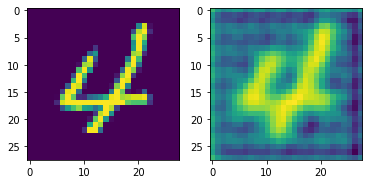

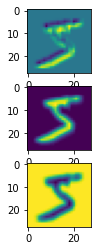

In [95]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

dataset = datasets.MNIST(
    root='PATH',
    transform=transforms.ToTensor(),
    download=True
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        print('Epoch {}, Batch idx {}, loss {}'.format(
            epoch, batch_idx, loss.item()))


def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Plot some images
idx = torch.randint(0, output.size(0), ())
pred = normalize_output(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)
output = model(data)

act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

In [106]:
data,_ = dataset[0]

In [109]:
act.shape

torch.Size([3, 28, 28])